In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
! pip install panphon # for conversion_tools
! pip install epitran

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 8.0 MB/s eta 0:00:00
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10744 sha256=30e66250269570196f3c6f644a7bf3bee161dfa1cd5f70a8b139a49a670f290f
  Stored in directory: /root/.cache/pip/wheels/f2/67/7d/2e80818c2f3dc8f0735d0810338c47e95d3212114ab97b4ede
Successfully built unicodecsv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 16.7 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from models import ResBlock, ASRModel
import conversion_tools as cv

In [5]:
# yor data
import gdown

# feature & data file
file_id = "18gejiyyyx3J1jVGnlOyPeFsgoDXVuoZr"
url = f"https://drive.google.com/uc?id={file_id}"
output = "tensor_file.pt"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=18gejiyyyx3J1jVGnlOyPeFsgoDXVuoZr
From (redirected): https://drive.google.com/uc?id=18gejiyyyx3J1jVGnlOyPeFsgoDXVuoZr&confirm=t&uuid=4f93a0bf-b382-454b-8908-c6267a041fb0
To: /content/tensor_file.pt
100%|██████████| 285M/285M [00:03<00:00, 88.9MB/s]


'tensor_file.pt'

In [6]:
# TIMIT arpa2idx
file_id = "1s20qxR1bBtx2c5YypYsMNTkSG8oicc_7"
url = f"https://drive.google.com/uc?id={file_id}"
output = "arpa2idx.txt"
gdown.download(url, output, quiet=False)

arpa2idx = dict()
with open('arpa2idx.txt', mode = 'r') as f:
  for line in f:
    arpa2idx[line.split()[0]] = int(line.split()[1])

idx2arpa = dict([idx, arpa] for arpa, idx in arpa2idx.items())

print('\n')
print(arpa2idx)
print(idx2arpa)

Downloading...
From: https://drive.google.com/uc?id=1s20qxR1bBtx2c5YypYsMNTkSG8oicc_7
To: /content/arpa2idx.txt
100%|██████████| 246/246 [00:00<00:00, 79.8kB/s]



{'a': 2, 'aa': 3, 'ae': 4, 'ah': 5, 'ao': 6, 'ax': 7, 'axr': 8, 'b': 9, 'ch': 10, 'd': 11, 'dh': 12, 'e': 13, 'eh': 14, 'er': 15, 'f': 16, 'g': 17, 'h': 18, 'hv': 19, 'ih': 20, 'ix': 21, 'iy': 22, 'jh': 23, 'k': 24, 'l': 25, 'm': 26, 'n': 27, 'ng': 28, 'o': 29, 'oh': 30, 'p': 31, 'q': 32, 'r': 33, 's': 34, 'sh': 35, 't': 36, 'th': 37, 'uh': 38, 'uw': 39, 'ux': 40, 'v': 41, 'w': 42, 'y': 43, 'z': 44, 'zh': 45, '<blank>': 0}
{2: 'a', 3: 'aa', 4: 'ae', 5: 'ah', 6: 'ao', 7: 'ax', 8: 'axr', 9: 'b', 10: 'ch', 11: 'd', 12: 'dh', 13: 'e', 14: 'eh', 15: 'er', 16: 'f', 17: 'g', 18: 'h', 19: 'hv', 20: 'ih', 21: 'ix', 22: 'iy', 23: 'jh', 24: 'k', 25: 'l', 26: 'm', 27: 'n', 28: 'ng', 29: 'o', 30: 'oh', 31: 'p', 32: 'q', 33: 'r', 34: 's', 35: 'sh', 36: 't', 37: 'th', 38: 'uh', 39: 'uw', 40: 'ux', 41: 'v', 42: 'w', 43: 'y', 44: 'z', 45: 'zh', 0: '<blank>'}


In [7]:
file_id = "1j8LoSxRSc13VpkNQq9B7Dxvcr-3T5Mop"
url = f"https://drive.google.com/uc?id={file_id}"
output = "ResNetCTC.pth.tar"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1j8LoSxRSc13VpkNQq9B7Dxvcr-3T5Mop
To: /content/ResNetCTC.pth.tar
100%|██████████| 9.65M/9.65M [00:00<00:00, 45.8MB/s]


'ResNetCTC.pth.tar'

In [8]:
features_data = torch.load("tensor_file.pt", weights_only=False)
print("Feature data type:", type(features_data))

print("Number of samples:", len(features_data))
print("First sample shape:", features_data[0].shape if hasattr(features_data[0], 'shape') else type(features_data[0]))

print("keys:", features_data[0].keys()) # mfcc, label, split > doesn't need "split" information
print("Feature Shape:", features_data[0]['mfcc'].shape) # should change to (num_steps, n_mfcc)
print("Label len:", len(features_data[0]['ipa'].split()))

print("Feature Sample:", features_data[0]['mfcc'])
print("Label Sample:", features_data[0]['ipa'])
print("Original Sample:", features_data[0]['sentence'])

Feature data type: <class 'list'>
Number of samples: 3077
First sample shape: <class 'dict'>
keys: dict_keys(['mfcc', 'ipa', 'sentence'])
Feature Shape: torch.Size([778, 39])
Label len: 35
Feature Sample: tensor([[-8.7377e+01,  3.3235e-06, -4.3032e-06,  ...,  1.0481e-04,
          4.0711e-06,  4.5165e-04],
        [-8.7377e+01,  3.3235e-06, -4.3032e-06,  ..., -3.7244e-02,
         -2.1835e-02, -1.4861e-02],
        [-8.7377e+01,  3.3235e-06, -4.3032e-06,  ..., -6.4962e-02,
         -4.4550e-02, -1.0477e-02],
        ...,
        [-4.6615e+01,  1.3341e+01, -3.6136e-01,  ...,  7.1048e-02,
          9.0596e-02,  2.4556e-01],
        [-4.6347e+01,  1.4126e+01, -6.2730e-01,  ...,  1.9275e-01,
          2.0640e-01,  1.2194e-01],
        [-4.6831e+01,  1.3333e+01, -4.5976e-01,  ...,  1.3538e-01,
          1.3054e-01, -5.6493e-02]])
Label Sample: / o t i k͡p e ɔ ɡ ɔ r u n u n ɔ d͡ʒ ɔ t i i d͡ʒ ɔ b a t i f o f ĩ d e w a /
Original Sample: Ó ti pé ọgọ́rùn-ún ọjọ́ tí ìjọba ti f'òfin de wá.


In [9]:
labels = pd.Series([item['ipa'] for item in features_data], dtype="string")
labels = labels.str.strip('/ ')  # remove sentence boundaries h#
labels = labels.str.replace(' | ', ' ').str.replace(' || ', ' ')  # remove pau and epi

In [10]:
unique_yor = set()
for label in labels:
  unique_yor = unique_yor.union(set(label.split()))
print(f"Number of Yoruba Phonemes in CommonVoice: {len(unique_yor)}")
print(' '.join(sorted(unique_yor)))

Number of Yoruba Phonemes in CommonVoice: 30
a ã b d d͡ʒ e f h i ĩ j k k͡p l m n o r s t u ũ w ɔ ɛ ɛ̃ ɡ ɡ͡b ʃ ʊ


In [11]:
labels.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3077 entries, 0 to 3076
Series name: None
Non-Null Count  Dtype 
--------------  ----- 
3077 non-null   string
dtypes: string(1)
memory usage: 24.2 KB


In [12]:
labels.at[0]

'o t i k͡p e ɔ ɡ ɔ r u n u n ɔ d͡ʒ ɔ t i i d͡ʒ ɔ b a t i f o f ĩ d e w a'

In [13]:
all_phones = labels.str.split(' ').explode()

/tmp/ipython-input-3527248285.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


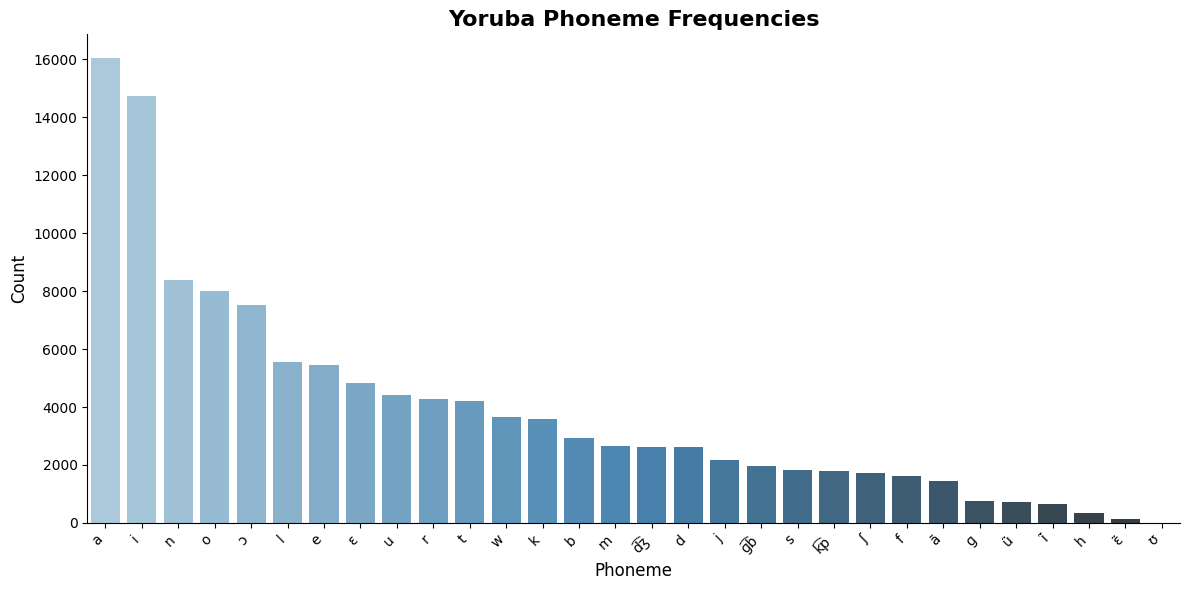

Unique phones: 30
Most common: a → 16061
Least common: ʊ → 1
Median frequency: 2645.5


In [14]:
# ai code
freqs = all_phones.value_counts()

plt.figure(figsize=(12,6))
sns.barplot(
    x=freqs.index,
    y=freqs.values,
    palette="Blues_d"
)
plt.title("Yoruba Phoneme Frequencies", fontsize=16, weight="bold")
plt.xlabel("Phoneme", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()

print("Unique phones:", freqs.shape[0])
print("Most common:", freqs.index[0], "→", freqs.iloc[0])
print("Least common:", freqs.index[-1], "→", freqs.iloc[-1])
print("Median frequency:", freqs.median())

In [15]:
# model configuration

with open('model_config.json') as f:
  MODEL_CONFIG = json.load(f)

MODEL_CONFIG

{'ip_channel': 39,
 'num_classes': 46,
 'num_res_blocks': 3,
 'num_cnn_layers': 1,
 'cnn_filters': 50,
 'cnn_kernel_size': 15,
 'num_rnn_layers': 2,
 'rnn_dim': 128,
 'num_dense_layers': 1,
 'dense_dim': 256,
 'use_birnn': True,
 'use_resnet': True,
 'rnn_type': 'lstm',
 'rnn_dropout': 0.4}

In [16]:
def decode_ctc(logits):
    pred = torch.argmax(logits, dim=-1).cpu().numpy()
    prev = -1
    output = []
    for p in pred:
        if p != prev and p != 0:  # remove duplicates and blanks
            output.append(idx2arpa[int(p)])
        prev = p
    return " ".join(output)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "ResNetCTC.pth.tar"

In [18]:
# --- Load model checkpoint ---
checkpoint_path = "checkpoint.pth"  # change to your trained model file
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ASRModel(**MODEL_CONFIG).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["state_dict"])
model.to(device)
model.eval() # set as evaluation mode

# Yoruba idx2label
yoruba_vocab = [str(phoneme) for phoneme in unique_yor]
idx2label = {i: c for i, c in enumerate(yoruba_vocab)}

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


In [19]:
# --- Load Yoruba dataset ---
yoruba_data = torch.load("tensor_file.pt")  # list of dicts with 'mfcc' and 'label' + 'split' information

# --- Zero-shot inference ---
test_pred = []
golden_label = []

pred_out = 'yor-predictions.txt'

with open(pred_out, mode = 'w') as f_out:
  for i, sample in enumerate(yoruba_data):
    mfcc = sample["mfcc"].to(device).unsqueeze(0).contiguous()
    with torch.no_grad():
        logits = model(mfcc)
        log_probs = F.log_softmax(logits, dim=-1)
        transcription = decode_ctc(log_probs[0])
        test_pred.append(transcription)
    f_out.write(transcription)
    f_out.write('\n')

    gt = labels[i]  # ground truth
    golden_label.append(gt)
    print(f"Sample {i}")
    print(f"   Predicted: {transcription}")
    print(f"   GroundTruth: {gt}")
print(f"Written {i + 1} predictions into {pred_out}")

Выходные данные были обрезаны до нескольких последних строк (5000).
   GroundTruth: a w ã k a n n ʃ ɔ d u n i t u n u a w ɛ w ã l ɔ d͡ʒ ɔ a i k u
Sample 1411
   Predicted: q ah v w ax ah t w ah ng ix d ah q ax y eh n q aa hv uw ax v ix q ix n ih n l ax n f ux sh eh n
   GroundTruth: ɔ k͡p ɔ l ɔ k͡p ɔ a w ã t o k u d i ɛ k a a t o l o ʃ i n b a w a ʃ i ʃ ɛ
Sample 1412
   Predicted: q a w y oh y n ah m ix n n ae w ax n q uw iy b l m y ih o l w a y n ix g iy ih n hv aa n ix n ix ng
   GroundTruth: ɔ w ɔ ɔ l ɔ k͡p a a t ɛ ɔ k u n r ĩ t o ɡ e ɔ w ɔ ɔ r ɛ b i n r ĩ r ɛ l a n a a
Sample 1413
   Predicted: iy ih ah l y ih n a n hv eh m ix ax m ax v ah l ax ix n n
   GroundTruth: i r a n j o r u b a d a r a k͡p u k͡p ɔ
Sample 1414
   Predicted: o w n ah m axr n m ix n zh ih dh iy ah n m ah n ux ax v e y ih g ix n g o w v ix d ax uw
   GroundTruth: a w ã ɔ m ɔ n a i d͡ʒ i r i a n k͡p a r i w o k͡p e i j a t o n d͡ʒ ɛ w ɔ n t i k͡p ɔ d͡ʒ u
Sample 1415
   Predicted: q ah n eh w r axr m l eh 

In [20]:
test_pred = []
with open('yor-predictions.txt', mode='r') as f_in:
  for line in f_in:
    test_pred.append(line)

test_pred = [cv.arpa_to_ipa(line) for line in test_pred]

# check predicted (unique) ipas
unique_eng = set()
for pred in test_pred:
  unique_eng = unique_eng.union(set(pred.split()))

In [21]:
' '.join(sorted(unique_eng))

'a b d d͡ʒ e f h i j k l m n o p s t t͡ʃ u v w z æ ð ŋ ɑ ɔ ə ə˞ ɛ ɜ˞ ɡ ɦ ɨ ɪ ɹ ʃ ʉ ʊ ʌ ʒ ʔ θ'

In [22]:
all_pred = pd.Series(test_pred).str.split(' ').explode()

/tmp/ipython-input-3567241853.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


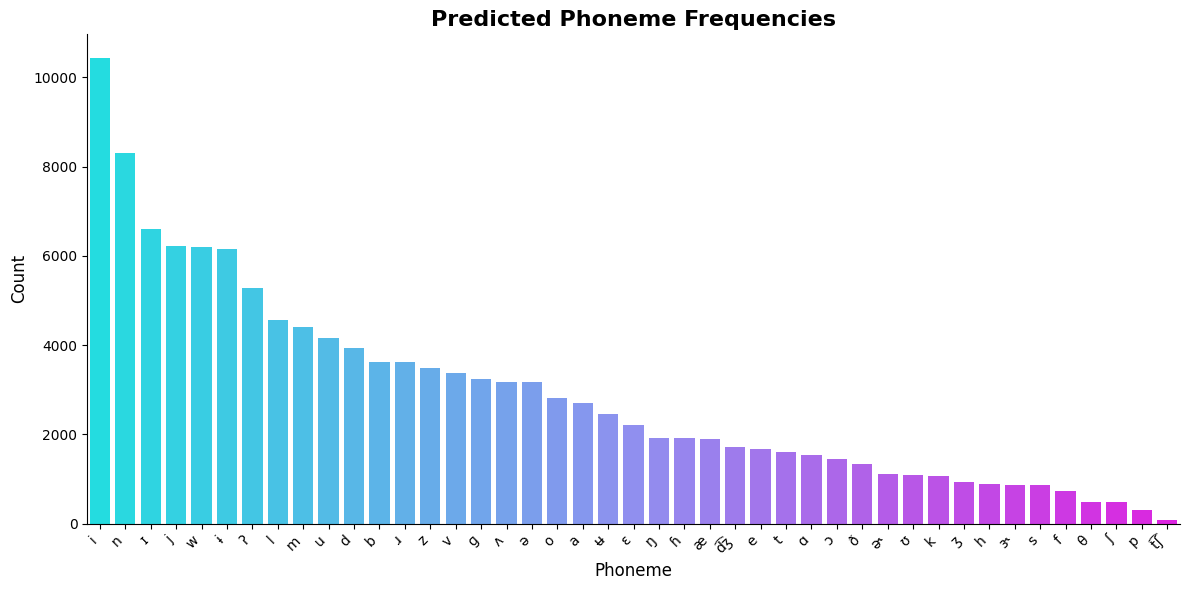

Unique phones: 43
Most common: i → 10443
Least common: t͡ʃ → 82
Median frequency: 2208.0


In [23]:
# ai code
eng_freqs = all_pred.value_counts()
turquoise = sns.color_palette("cool", n_colors=len(unique_eng))

plt.figure(figsize=(12,6))
sns.barplot(
    x=eng_freqs.index,
    y=eng_freqs.values,
    palette=turquoise
)
plt.title("Predicted Phoneme Frequencies", fontsize=16, weight="bold")
plt.xlabel("Phoneme", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()

print("Unique phones:", eng_freqs.shape[0])
print("Most common:", eng_freqs.index[0], "→", eng_freqs.iloc[0])
print("Least common:", eng_freqs.index[-1], "→", eng_freqs.iloc[-1])
print("Median frequency:", eng_freqs.median())

In [24]:
# I observed a connection between similar sounds having similar frequencies
# That's an indirect sign of our model working correctly
# It it impossible to measure even with feature closeness and frequency closeness

In [25]:
for pred, gold in zip(test_pred[:5], golden_label[:5]):
  print(f"\nPredictions: {pred}")
  print(f"Golden labels {gold}")


Predictions: n ɪ z ɨ ŋ n ɦ i m u m m ɪ n ɪ b ɨ ɦ u m ɨ ɨ n ɦ ɪ z i i e v ɨ ŋ z i ɪ m m ɛ s i ʉ m ɨ m ɦ i n ɦ i ɑ ɹ m u n ɨ n ɦ u ʉ
Golden labels o t i k͡p e ɔ ɡ ɔ r u n u n ɔ d͡ʒ ɔ t i i d͡ʒ ɔ b a t i f o f ĩ d e w a

Predictions: ʔ ɹ z z ɡ u m i o w n ʔ ʊ ɡ w ə˞ i ʔ e j ɪ l k ə w ɛ n ɹ i n m k i n i b i v i ɨ j e j ɑ j ɪ i
Golden labels ɡ o m i n a o b i n r ĩ ɛ j ɔ k a n k͡p e r e l a t i n i n i i k͡p i n l ɛ a j e d e

Predictions: ʔ ʔ i n u l ʔ æ w ə z i l ɜ˞ ŋ ɹ i ɛ n d ɛ n i ɡ w b w ɨ n w w w ɑ ɹ s ɜ˞ ɹ i z i
Golden labels ĩ u a b o t i n l a n i a d͡ʒ a n i k o ɡ͡b o ɡ͡b o a w ã a ʃ ɔ r ɛ s i

Predictions: ʔ o w z i ʔ ɡ i ʔ ɪ θ ɪ h ə ɨ i t d͡ʒ i n z i ɑ m ɛ ʔ i ð ɪ ɪ j i ɹ æ d i f l ɑ t k a j m i
Golden labels k o s i i w e ɛ r i f ũ o l u d i d͡ʒ e t i a w ã ɛ ɡ͡b ɛ o n i ɡ͡b a a l ɛ f a k a l ɛ

Predictions: ʔ o w m w ɨ ɪ θ s i ð æ t a ʃ e j t ɡ ʌ m b ɨ m ɨ i m o w w ʔ d u ʌ
Golden labels a m ɔ t ɛ k u n t i ɡ͡b a a ʃ ɛ i d a a b o b o l ɔ w ɔ i d͡ʒ ɔ b a


In [26]:
for pred, label in zip(test_pred[:3], golden_label[:3]):
  alignment, score = cv.feature_edit_alignment(pred, label, d=lambda x: 0.5)
  print(f"\nDistance: {round(score, 2)}\
  \n ENG -> {pred}\
  \n YOR -> {label}")
  for src, tgt in alignment:
    print(f"{src:5} → {tgt:5}")


Distance: 20.29  
 ENG -> n ɪ z ɨ ŋ n ɦ i m u m m ɪ n ɪ b ɨ ɦ u m ɨ ɨ n ɦ ɪ z i i e v ɨ ŋ z i ɪ m m ɛ s i ʉ m ɨ m ɦ i n ɦ i ɑ ɹ m u n ɨ n ɦ u ʉ  
 YOR -> o t i k͡p e ɔ ɡ ɔ r u n u n ɔ d͡ʒ ɔ t i i d͡ʒ ɔ b a t i f o f ĩ d e w a
n     → ε    
ɪ     → ε    
z     → ε    
ɨ     → o    
ŋ     → ε    
n     → t    
ɦ     → ε    
i     → i    
m     → ε    
u     → ε    
m     → k͡p  
m     → ε    
ɪ     → e    
n     → ε    
ɪ     → ɔ    
b     → ɡ    
ɨ     → ɔ    
ɦ     → r    
u     → u    
m     → n    
ɨ     → ε    
ɨ     → u    
n     → n    
ɦ     → ε    
ɪ     → ɔ    
z     → d͡ʒ  
i     → ɔ    
i     → t    
e     → i    
v     → ε    
ɨ     → i    
ŋ     → ε    
z     → d͡ʒ  
i     → ε    
ɪ     → ɔ    
m     → ε    
m     → b    
ɛ     → a    
s     → t    
i     → i    
ʉ     → ε    
m     → f    
ɨ     → o    
m     → f    
ɦ     → ε    
i     → ĩ   
n     → d    
ɦ     → ε    
i     → e    
ɑ     → ε    
ɹ     → ε    
m     → ε    
u     → w    
n     → ε    
ɨ     → a    
n 

In [27]:
alignments = []
scores = []

for pred, label in zip(test_pred, golden_label):
    a, s = cv.feature_edit_alignment(pred, label, d=lambda x: 0.4)  # make deletion cheap
    alignments.append(a)
    scores.append(s/len(label.split()))

alignments = pd.DataFrame([alignments, scores, test_pred, golden_label],
                          index=['Alignment', 'Score', 'Model_pred', 'Yoruba_label']).T
alignments.sort_values(by='Score', ascending=True, inplace=True)

In [29]:
def show_alignment(row):
    print(f"\nDistance: {round(row['Score'] * len(row['Yoruba_label'].split()), 2)}\
            \n ENG -> {row['Model_pred']}\n YOR -> {row['Yoruba_label']}")
    for src, tgt in row['Alignment']:
        print(f"{src:5} → {tgt:5}")
    return None

print("Two best predictions:")
for _, e in alignments.head(2).iterrows():
    show_alignment(e)

print("\nTwo worst predictions:")
for _, e in alignments.tail(2).iloc[::-1].iterrows():
    show_alignment(e)

print("\nA median prediction:")
medidx = len(alignments) // 2
show_alignment(alignments.loc[medidx])

Two best predictions:

Distance: 8.45            
 ENG -> ʔ a j e j j u m i m ɪ ɹ j d z ɨ b ɛ ɹ ɛ m i ɑ n ʌ n ə k ɨ ʔ ɡ ʉ s i t t͡ʃ i ɹ æ ʃ ɔ j e j ɛ n m i
 YOR -> a j ɛ j ɛ o m i n i r a t i b ɛ r ɛ n i a n a m o s i t i r a a ʃ ɔ a j ɛ j ɛ m i
ʔ     → ε    
a     → a    
j     → j    
e     → ɛ    
j     → j    
j     → ɛ    
u     → o    
m     → m    
i     → i    
m     → n    
ɪ     → i    
ɹ     → r    
j     → a    
d     → t    
z     → ε    
ɨ     → i    
b     → b    
ɛ     → ɛ    
ɹ     → r    
ɛ     → ɛ    
m     → n    
i     → i    
ɑ     → a    
n     → n    
ʌ     → a    
n     → m    
ə     → o    
k     → s    
ɨ     → i    
ʔ     → ε    
ɡ     → ε    
ʉ     → ε    
s     → t    
i     → i    
t     → r    
t͡ʃ   → ε    
i     → a    
ɹ     → ε    
æ     → a    
ʃ     → ʃ    
ɔ     → ɔ    
ε     → a    
j     → j    
e     → ɛ    
j     → j    
ɛ     → ɛ    
n     → ε    
m     → m    
i     → i    

Distance: 8.52            
 ENG -> w ɨ n z i n ɪ n i ɪ n ɪ ʒ d͡ʒ ɪ 

In [30]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(golden_label, test_pred, normalize=None,
#                       # sklearn ≥1.4
#                       # sparse_output=True
#                      )

In [31]:
pred = [l.replace(" ", "") for l in test_pred]
gold = [l.replace(" ", "") for l in golden_label]

In [32]:
matrix = cv.make_confusion_matrix(pred, gold, form="given_gold")
matrix = matrix.drop('ʊ', axis=1)  # only once in data
# to avoid confusion with open-mid front vowel
matrix.columns = matrix.columns.str.replace('ε', '∅')
matrix.index = matrix.index.str.replace('ε', '∅')

In [33]:
matrix = (matrix * 100).round(2)

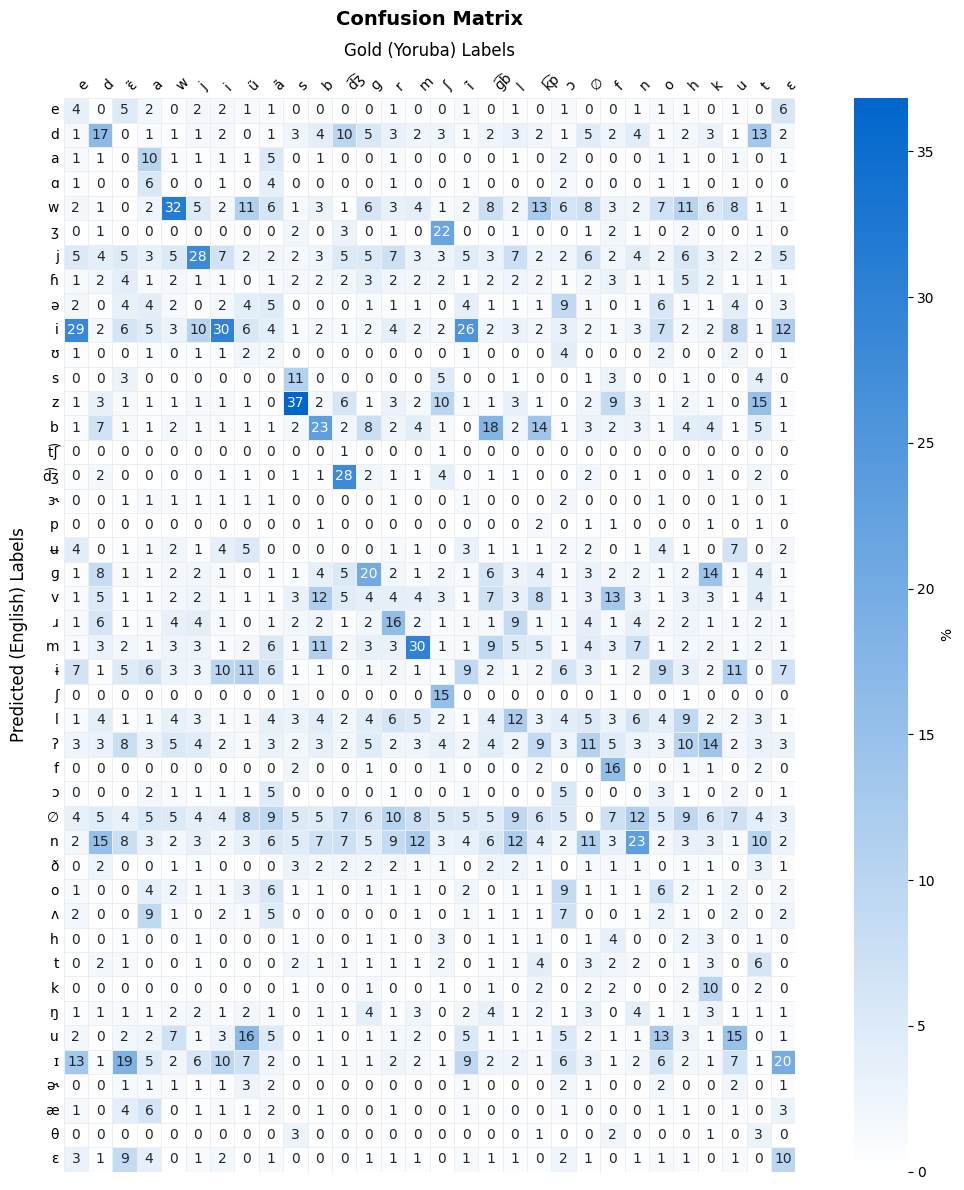

In [34]:
colors = LinearSegmentedColormap.from_list("white_to_blue", ["#ffffff", "#0066CC"])

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(
    matrix,
    annot=True,
    fmt=".0f",
    cmap=colors,
    square=True,
    linewidths=0.5,
    linecolor="#eeeeee",
    cbar_kws={"label": "%"},
    ax=ax
)

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

ax.tick_params(axis='x', top=True, length=0)
ax.tick_params(axis='y', length=0)  # optional: remove from y-axis too

ax.set_xlabel("Gold (Yoruba) Labels", fontsize=12, labelpad=10)
ax.set_ylabel("Predicted (English) Labels", fontsize=12, labelpad=10)
ax.set_title("Confusion Matrix", fontsize=14, fontweight='bold', pad=12)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()



In [35]:
cv.phoneme_error_rate(pred, gold, d=lambda x: 0.4, i=lambda x: 0.75)

np.float64(0.34856574804836365)

In [36]:
en_given_yor = matrix / 100
logprobs = np.log2(en_given_yor)
H_given_yor = -(en_given_yor * logprobs).sum(axis=0).round(2)
H_given_yor.name = 'H'

/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


In [37]:
H_given_yor.sort_values(ascending=False)

,H
∅,4.71
a,4.70
ã,4.70
ɔ,4.69
h,4.64
o,4.59
r,4.54
l,4.53
f,4.48
k͡p,4.48


In [38]:
# add coocurrences to the conversion methods

In [39]:
noempty = matrix.drop('∅', axis=1).drop('∅', axis=0)
# noempty = noempty.T
empirical_correspondences = pd.Series([noempty[y].nlargest(4).index.values for y in noempty],
                                      index=noempty.columns, name="Top 4 confusions")


In [40]:
from panphon import FeatureTable
ft = FeatureTable()
def fourclosest(phone: str, inventory: list) -> list[str]:
    di = [cv.compute_ipa_distance(phone, comp, ft) for comp in inventory]
    di = pd.Series(di, index=inventory)
    return di.nsmallest(4).index.values

In [41]:
empirical_vs_theoretical = pd.DataFrame(empirical_correspondences)
empirical_vs_theoretical['Top 4 closest'] = empirical_correspondences.index.to_series().apply(
    lambda x: fourclosest(x, noempty.index))

In [42]:
empirical_vs_theoretical['Confusion H'] = H_given_yor.drop('∅')

In [43]:
empirical_vs_theoretical.sort_values(by='Confusion H', ascending=True)

,Top 4 confusions,Top 4 closest,Confusion H
s,"[z, s, n, v]","[s, z, ʃ, t]",3.82
d͡ʒ,"[d͡ʒ, d, n, z]","[d͡ʒ, t͡ʃ, ʒ, ʃ]",4.00
m,"[m, n, l, w]","[m, b, n, p]",4.01
i,"[i, ɨ, ɪ, j]","[i, e, ɨ, ɪ]",4.08
e,"[i, ɪ, ɨ, j]","[e, i, ʌ, æ]",4.12
b,"[b, v, m, n]","[b, p, v, m]",4.13
w,"[w, u, j, ʔ]","[w, u, ɜ˞, ʉ]",4.14
ʃ,"[ʒ, ʃ, z, s]","[ʃ, ʒ, s, t͡ʃ]",4.17
ɛ̃,"[ɪ, ɛ, ʔ, n]","[ɛ, e, ə, ɪ]",4.18
ĩ,"[i, ɪ, ɨ, u]","[i, e, ɨ, ɪ]",4.22


In [44]:
# bootstrapping PER
deletion_cost = lambda x: 0.5
insertion_cost = lambda x: 0.75
seed = 119

# our result

print("Our result:", cv.phoneme_error_rate(test_pred, golden_label, d=deletion_cost, i=insertion_cost).round(2))

Our result: 0.36


In [54]:
modela = []
modelsc = []

for pred, label in zip(test_pred, golden_label):
    a, s = cv.feature_edit_alignment(pred, label, d=deletion_cost, i=insertion_cost)
    modela.append(a)
    modelsc.append(s/len(label.split()))

model_alignments = pd.DataFrame([modela, modelsc, test_pred, golden_label],
                          index=['Alignment', 'Score', 'Model_pred', 'Yoruba_label']).T
model_alignments.sort_values(by='Score', ascending=True, inplace=True)

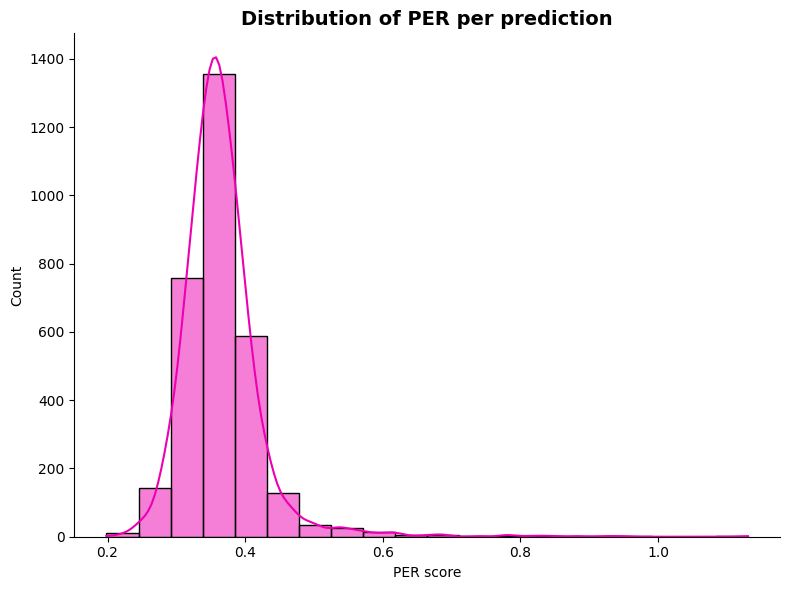

In [58]:
plt.figure(figsize=(8,6))
ax = sns.histplot(model_alignments['Score'], bins=20, kde=True, color="#ED00B1")
plt.title("Distribution of PER per prediction", fontsize=14, weight="bold")
plt.xlabel("PER score")
plt.ylabel("Count")
sns.despine()
plt.tight_layout()
plt.show()
for_comparison = ax.get_xlim()

In [56]:
# equal probability, same lengths as predictions

import random
random.seed(seed)

L = list(unique_eng)
lengths = pd.Series(test_pred).str.split().str.len()

one_gen = lengths.apply(lambda x: random.choices(L, k=x))
one_gen = one_gen.str.join('').to_list()
one_per = cv.phoneme_error_rate(one_gen, gold, d=deletion_cost, i=insertion_cost)
print("A random sequence result:", one_per.round(2))

A random sequence result: 0.44


In [53]:
# unigram probability, same lengths as predictions
weights = eng_freqs.reindex(L).values.tolist()  # probs of letters
one_gen = lengths.apply(lambda x: random.choices(L, k=x, weights=weights))
one_gen = one_gen.str.join('').to_list()
one_per = cv.phoneme_error_rate(one_gen, gold, d=deletion_cost, i=insertion_cost)

print("A unigram model random sequence result:", one_per.round(2))

A unigram model random sequence result: 0.42


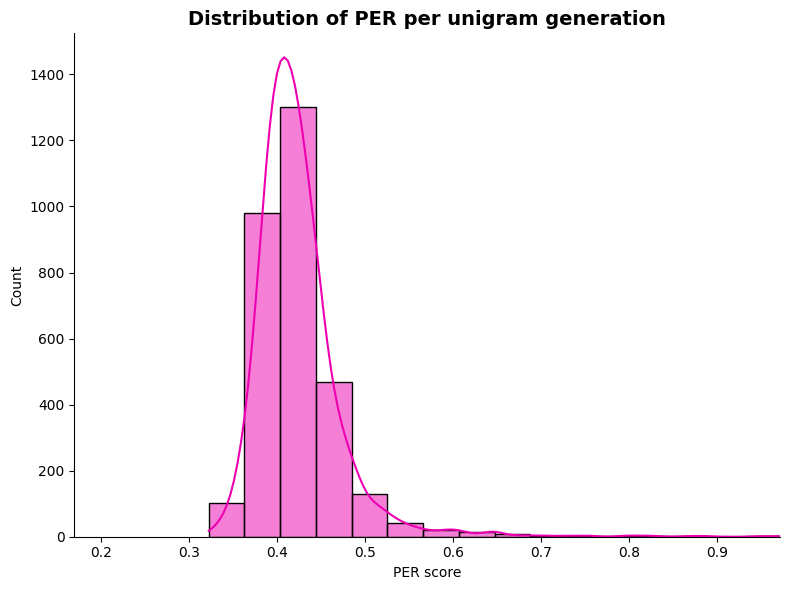

In [47]:
randa = []
rands = []

one_gen = lengths.apply(lambda x: random.choices(L, k=x, weights=weights))
one_gen = one_gen.str.join(' ').to_list()
for rand, label in zip(one_gen, golden_label):
    a, s = cv.feature_edit_alignment(rand, label, d=deletion_cost, i=insertion_cost)
    randa.append(a)
    rands.append(s/len(label.split()))

plt.figure(figsize=(8,6))
ax2 = sns.histplot(rands, bins=20, kde=True, color="#ED00B1")
ax2.set_xlim(for_comparison)
plt.title("Distribution of PER per unigram generation", fontsize=14, weight="bold")
plt.xlabel("PER score")
plt.ylabel("Count")
sns.despine()
plt.tight_layout()
plt.show()

In [48]:
# bigram probability, rndom lengthsf
import nltk
from nltk import bigrams, ConditionalFreqDist

corpus = ['/']
for se in test_pred:
    for ph in se.split():
        corpus.append(ph)
    corpus.append('/')

cfd = ConditionalFreqDist(bigrams(corpus))

In [49]:
def next_phone(ph):
    dist = cfd[ph]
    return random.choices(list(dist.keys()), weights=dist.values(), k=1)[0]
def gen_pred():
    before ='/'
    for _ in range(60):
        after = next_phone(before)
        if after == '/':
            return
        yield after
        before = after

In [50]:
one_gen = lengths.apply(lambda x: ''.join(gen_pred())).to_list()
one_per = cv.phoneme_error_rate(one_gen, gold, d=deletion_cost, i=insertion_cost)

print("A bigram model random sequence result:", one_per.round(2))

A bigram model random sequence result: 0.5283164939972738


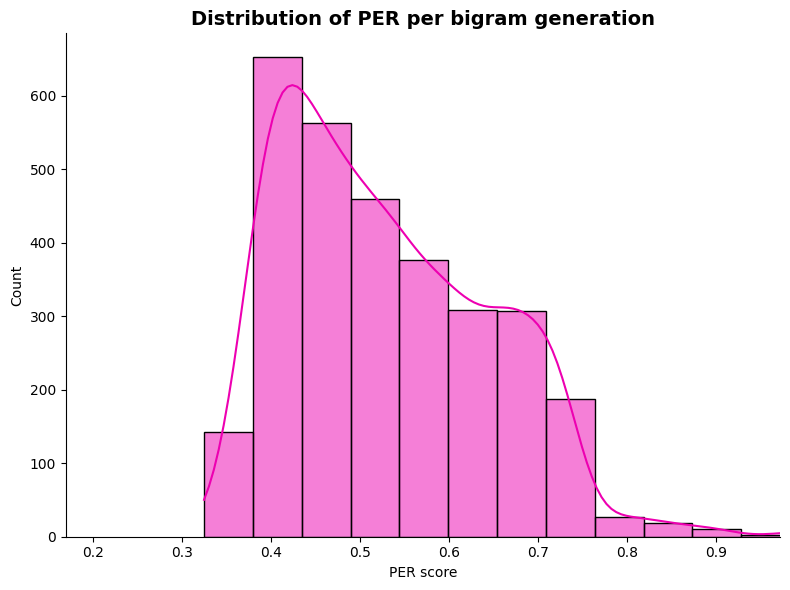

In [51]:
randa = []
rands = []

one_gen = lengths.apply(lambda x: ' '.join(gen_pred())).to_list()
for rand, label in zip(one_gen, golden_label):
    a, s = cv.feature_edit_alignment(rand, label, d=deletion_cost, i=insertion_cost)
    randa.append(a)
    rands.append(s/len(label.split()))

plt.figure(figsize=(8,6))
ax2 = sns.histplot(rands, bins=20, kde=True, color="#ED00B1")
ax2.set_xlim(for_comparison)
plt.title("Distribution of PER per bigram generation", fontsize=14, weight="bold")
plt.xlabel("PER score")
plt.ylabel("Count")
sns.despine()
plt.tight_layout()
plt.show()